In [10]:
import numpy as np
import torch
torch.set_default_dtype(torch.double)
import matplotlib.pyplot as plt
from matplotlib import cm

The Müller potential is defined as

\begin{equation*}
U(x, y; \alpha) = \alpha \cdot \sum_{i=1}^{4}{A_i \cdot \exp( \left[ a_i \cdot (x-x^0_i)^2 + b_i \cdot (x-x^0_i)(y-y^0_i) + c_i \cdot (y-y^0_i)^2 \right] )}
\end{equation*}

where $(A_1, A_2, A_3, A_4)$ = (-200, -100, -170, 15), $(a_1, a_2, a_3, a_4)$ = (-1, -1, -6.5, 0.7), $(b_1, b_2, b_3, b_4)$ = (0, 0, 11, 0.6),$(c_1, c_2, c_3, c_4)$ = (-10, -10, -6.5, 0.7), $(x^0_1, x^0_2, x^0_3, x^0_4)$ =  (1, 0, -0.5, -1), and $(y^0_1, y^0_2, y^0_3, y^0_4)$ = (0, 0.5, 1.5, 1).

$\alpha$ is a parameter that control the rugedness of the potential. In this tutorial, we will set it to 0.05.


In [15]:
def compute_Muller_potential(x, alpha):
    A = (-200., -100., -170., 15.)
    b = (0., 0., 11., 0.6)
    ac = (x.new_tensor([-1.0, -10.0]),
          x.new_tensor([-1.0, -10.0]),
          x.new_tensor([-6.5, -6.5]),
          x.new_tensor([0.7, 0.7]))

    x0 = (x.new_tensor([ 1.0, 0.0]),
          x.new_tensor([ 0.0, 0.5]),
          x.new_tensor([-0.5, 1.5]),
          x.new_tensor([-1.0, 1.0]))

    U = 0
    for i in range(4):
        diff = x - x0[i]
        U = U + A[i]*torch.exp(torch.sum(ac[i]*diff**2, -1) + b[i]*torch.prod(diff, -1))

    U = alpha * U
    return U

In [16]:
def generate_grid(x1_min, x1_max, x2_min, x2_max, size = 100):
    x1 = torch.linspace(x1_min, x1_max, size)
    x2 = torch.linspace(x2_min, x2_max, size)
    grid_x1, grid_x2 = torch.meshgrid(x1, x2)
    grid = torch.stack([grid_x1, grid_x2], dim = -1)
    x = grid.reshape((-1, 2))
    return x

In [17]:
alpha = 0.05
x1_min, x1_max = -1.5, 1.0
x2_min, x2_max = -0.5, 2.0

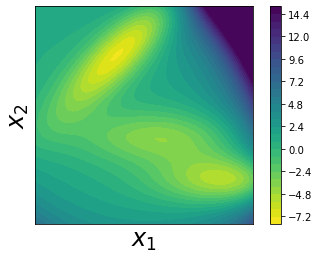

In [18]:
x = generate_grid(x1_min, x1_max, x2_min, x2_max)
fig, axes = plt.subplots()
alpha = 0.05
U = compute_Muller_potential(x, alpha)
U = U.reshape(100, 100)
U[U>15] = 15
U = U.T
plt.contourf(U, levels = 30, extent = (x1_min, x1_max, x2_min, x2_max), cmap = cm.viridis_r)
plt.xlabel(r"$x_1$", fontsize = 24)
plt.ylabel(r"$x_2$", fontsize = 24)
plt.colorbar()
plt.tight_layout()
axes.set_aspect('equal')
plt.tick_params(which='both', bottom=False, top=False, right = False, left = False, labelbottom=False, labelleft=False)
#    plt.savefig("./output/true_muller_energy_alpha_{:.3f}.png".format(alpha))
#plt.savefig("./output/true_muller_energy_alpha_{:.3f}.eps".format(alpha))

In [20]:
num_reps = 10
alphas = torch.linspace(0.0, alpha, num_reps)

num_steps = 510000
x_record = []
accept_rate = 0
x = torch.stack((x1_min + torch.rand(num_reps)*(x1_max - x1_min),
                 x2_min + torch.rand(num_reps)*(x2_max - x2_min)),
                dim = -1)
energy = compute_Muller_potential(x, 1.0)

for k in range(num_steps):
    if (k + 1) % 100000 == 0:
        print("idx of steps: {}".format(k))

    ## sampling within each replica
    delta_x = torch.normal(0, 1, size = (num_reps, 2))*0.3
    x_p = x + delta_x
    energy_p = compute_Muller_potential(x_p, 1.0)

    ## accept based on energy
    accept_prop = torch.exp(-alphas*(energy_p - energy))
    accept_flag = torch.rand(num_reps) < accept_prop

    ## considering the bounding effects
    accept_flag = accept_flag & torch.all(x_p > x_p.new_tensor([x1_min, x2_min]), -1) \
                              & torch.all(x_p < x_p.new_tensor([x1_max, x2_max]), -1)

    x_p[~accept_flag] = x[~accept_flag]
    energy_p[~accept_flag] = energy[~accept_flag]
    x = x_p
    energy = energy_p

    ## calculate overall accept rate
    accept_rate = accept_rate + (accept_flag.float() - accept_rate)/(k+1)
    
    ## exchange
    if k % 10 == 0:
        for i in range(1, num_reps):
            accept_prop = torch.exp((alphas[i] - alphas[i-1])*(energy[i] - energy[i-1]))
            accept_flag = torch.rand(1) < accept_prop
            if accept_flag.item():
                tmp = x[i]
                x[i] = x[i-1]
                x[i-1] = tmp

                tmp = energy[i]
                energy[i] = energy[i-1]
                energy[i-1] = tmp
        if k >= 10000:
            x_record.append(x.clone().numpy())
            
x_record = np.array(x_record)

idx of steps: 99999
idx of steps: 199999
idx of steps: 299999
idx of steps: 399999
idx of steps: 499999


In [21]:
x_record.shape

(50000, 10, 2)